In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

import sys
from os.path import join, abspath
from os import pardir, getcwd
sys.path.append(abspath(join(getcwd(), pardir, pardir)))

from configuration import Config
config = Config()

figure_path = join(config.project_path, 'generated/figures')

In [2]:
def make_system_name(row) -> str:
    
    match row.architecture:
        case 'clpgpt':
            architecture = 'CC'
        case 'trf':
            architecture = 'TRF'
    
    match row.context:
        case 'global':
            context = 'vis'
        case 'nocontext':
            context = 'tgt'
        case 'scene':
            context = 'sym'
            
    return f'{architecture}$_{{{context}}}$'
    # return f'{architecture}$_{{{context}-{row.noise}}}$'

def concat_dfs(dfs):
    merged = pd.concat(dfs)
    merged['context'] = pd.Categorical(merged['context'], ["nocontext", "global", "scene"])
    merged = merged.sort_values(
        by=['dataset', 'architecture', 'split', 'noise', 'context'],
        ascending=[True, False, True, True, True]
    )
    return merged

def make_system_idx(x):
    return f'{x.dataset}_{x.split}_{x.architecture}_{x.context}_{x.noise}'

def mean_scores_for_repeated_inference(df):
    # new joint idx for files for the same system
    df['system_idx'] = df.apply(make_system_idx, axis=1)
    
    # aggregate scores / mean
    df = df.groupby('system_idx').agg({
        'system_name': 'first', 
        'Bleu_1': 'mean', 
        'Bleu_2': 'mean', 
        'Bleu_3': 'mean', 
        'Bleu_4': 'mean', 
        'CIDEr': 'mean',
        'ROUGE_L': 'mean', 
        'architecture': 'first', 
        'context': 'first', 
        'dataset': 'first', 
        #'file_idx': 'first', 
        'noise': 'first',
        'split': 'first', 
        #'system_idx': 'first'
        }).set_index('system_name')
    
    return df

In [3]:
metric_files = sorted(glob(
    join(config.project_path, 'generated/automatic_metrics/**/**/**.csv')
))

In [4]:
metrics = [
    'Bleu_1', 
    'Bleu_2', 
    #'Bleu_3', 
    #'Bleu_4', 
    'CIDEr', 
    #'ROUGE_L'
]

In [5]:
set_split_files = dict()
for dataset in 'refcoco', 'refcoco+':
    for split in 'testA', 'testB':
        files = sorted(glob(
            join(config.project_path, f'generated/automatic_metrics/**/**/**{dataset}_{split}_metrics.csv')
            ), reverse=True)
        set_split_files[f'{dataset}_{split}'] = files

In [6]:
dfs_and_supercolumns = []
splits = ['testA', 'testB', 'testA+', 'testB+']
columns_selection = metrics + ['noise']
for setsplit, df_files in set_split_files.items():
    if len(df_files) > 0:
        dfs = [
            pd.read_csv(file).rename(columns={'Unnamed: 0': 'system_name'})
            for file in df_files
        ]
        mean_dfs = [mean_scores_for_repeated_inference(df) for df in dfs]
        concatenated = concat_dfs(mean_dfs)
        concatenated['system'] = concatenated.apply(make_system_name, axis=1)
        concatenated = concatenated.set_index('system')#[columns_selection]
        
        dataset, split = setsplit.split('_')
        supercolumn = split + ('+' if dataset == 'refcoco+' else '')
        
        dfs_and_supercolumns.append((concatenated, supercolumn))
        
full_table = pd.concat({supercolumn: df for df, supercolumn in dfs_and_supercolumns}, axis=1)

In [7]:
assert not False in full_table.apply(
    lambda x: x['testA']['noise'] == x['testB']['noise'] == x['testA+']['noise'] == x['testB+']['noise'], 
    axis=1
).values
assert not False in full_table.apply(
    lambda x: x['testA']['architecture'] == x['testB']['architecture'] == x['testA+']['architecture'] == x['testB+']['architecture'], 
    axis=1
).values
assert not False in full_table.apply(
    lambda x: x['testA']['context'] == x['testB']['context'] == x['testA+']['context'] == x['testB+']['context'], 
    axis=1
).values

full_table.insert(0, ('context', '{}'), full_table['testA']['context'])
full_table.insert(0, ('architecture', '{}'), full_table['testA']['architecture'])
full_table.insert(0, ('noise', '{}'), full_table['testA']['noise'])

remove_subcols = ['dataset', 'context', 'architecture', 'noise', 'split', 'ROUGE_L', 'Bleu_3', 'Bleu_4']
remove_cols = [(s, i) for s in splits for i in remove_subcols]
full_table = full_table.drop(columns=remove_cols)

In [8]:
full_table.round(2)

noise architecture    context  testA               testB         \
               {}           {}         {} Bleu_1 Bleu_2 CIDEr Bleu_1 Bleu_2   
system                                                                        
TRF$_{tgt}$   0.0          trf  nocontext   0.55   0.35  0.86   0.57   0.35   
TRF$_{vis}$   0.0          trf     global   0.58   0.39  0.93   0.61   0.39   
TRF$_{sym}$   0.0          trf      scene   0.54   0.34  0.84   0.57   0.35   
TRF$_{tgt}$   0.5          trf  nocontext   0.49   0.32  0.73   0.52   0.32   
TRF$_{vis}$   0.5          trf     global   0.53   0.35  0.81   0.56   0.36   
TRF$_{sym}$   0.5          trf      scene   0.53   0.35  0.81   0.57   0.35   
TRF$_{tgt}$   1.0          trf  nocontext   0.35   0.17  0.34   0.30   0.14   
TRF$_{vis}$   1.0          trf     global   0.46   0.29  0.60   0.55   0.36   
TRF$_{sym}$   1.0          trf      scene   0.42   0.24  0.51   0.53   0.33   
CC$_{tgt}$    0.0       clpgpt  nocontext   0.48   0.30  0.70   0.47   0.28   
CC$_{vis}$    0.0       clpgpt     global   0.57   0.38  0.92   0.58   0.37   
CC$_{sym}$    0.0       clpgpt      scene   0.45   0.28  0.66   0.56   0.36   
CC$_{tgt}$    0.5       clpgpt  nocontext   0.38   0.21  0.48   0.36   0.20   
CC$_{vis}$    0.5       clpgpt     global   0.51   0.32  0.75   0.50   0.31   
CC$_{sym}$    0.5       clpgpt      scene   0.44   0.27  0.61   0.57   0.36   
CC$_{tgt}$    1.0       clpgpt  nocontext   0.35   0.16  0.37   0.29   0.12   
CC$_{vis}$    1.0       clpgpt     global   0.40   0.23  0.46   0.38   0.21   
CC$_{sym}$    1.0       clpgpt      scene   0.42   0.25  0.52   0.55   0.34   

                  testA+              testB+               
            CIDEr Bleu_1 Bleu_2 CIDEr Bleu_1 Bleu_2 CIDEr  
system                                                     
TRF$_{tgt}$  1.28   0.49   0.31  0.77   0.36   0.19  0.68  
TRF$_{vis}$  1.36   0.50   0.32  0.83   0.37   0.20  0.73  
TRF$_{sym}$  1.27   0.46   0.29  0.78   0.37   0.19  0.72  
TRF$_{tgt}$  1.06   0.42   0.27  0.64   0.29   0.14  0.53  
TRF$_{vis}$  1.24   0.43   0.26  0.67   0.34   0.18  0.62  
TRF$_{sym}$  1.28   0.45   0.29  0.71   0.36   0.19  0.68  
TRF$_{tgt}$  0.20   0.29   0.15  0.20   0.07   0.01  0.04  
TRF$_{vis}$  1.14   0.32   0.17  0.34   0.29   0.14  0.47  
TRF$_{sym}$  1.12   0.31   0.15  0.31   0.30   0.14  0.48  
CC$_{tgt}$   0.88   0.42   0.27  0.70   0.29   0.14  0.53  
CC$_{vis}$   1.25   0.45   0.29  0.77   0.33   0.18  0.62  
CC$_{sym}$   1.22   0.44   0.28  0.73   0.37   0.20  0.70  
CC$_{tgt}$   0.51   0.40   0.25  0.64   0.27   0.14  0.47  
CC$_{vis}$   0.97   0.41   0.26  0.68   0.30   0.16  0.55  
CC$_{sym}$   1.17   0.35   0.21  0.46   0.33   0.17  0.57  
CC$_{tgt}$   0.16   0.27   0.14  0.20   0.10   0.02  0.06  
CC$_{vis}$   0.46   0.29   0.15  0.30   0.20   0.09  0.27  
CC$_{sym}$   1.17   0.31   0.16  0.32   0.32   0.16  0.53

In [9]:
print(
    full_table[['noise'] + splits].round(2).rename(columns={'Bleu_1': 'Bl$_1$', 'Bleu_2': 'Bl$_2$', 'CIDEr': 'CDr'}).to_latex(escape=False)
)

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
{} & noise & \multicolumn{3}{l}{testA} & \multicolumn{3}{l}{testB} & \multicolumn{3}{l}{testA+} & \multicolumn{3}{l}{testB+} \\
{} &    {} & Bl$_1$ & Bl$_2$ &   CDr & Bl$_1$ & Bl$_2$ &   CDr & Bl$_1$ & Bl$_2$ &   CDr & Bl$_1$ & Bl$_2$ &   CDr \\
system      &       &        &        &       &        &        &       &        &        &       &        &        &       \\
\midrule
TRF$_{tgt}$ &   0.0 &   0.55 &   0.35 &  0.86 &   0.57 &   0.35 &  1.28 &   0.49 &   0.31 &  0.77 &   0.36 &   0.19 &  0.68 \\
TRF$_{vis}$ &   0.0 &   0.58 &   0.39 &  0.93 &   0.61 &   0.39 &  1.36 &   0.50 &   0.32 &  0.83 &   0.37 &   0.20 &  0.73 \\
TRF$_{sym}$ &   0.0 &   0.54 &   0.34 &  0.84 &   0.57 &   0.35 &  1.27 &   0.46 &   0.29 &  0.78 &   0.37 &   0.19 &  0.72 \\
TRF$_{tgt}$ &   0.5 &   0.49 &   0.32 &  0.73 &   0.52 &   0.32 &  1.06 &   0.42 &   0.27 &  0.64 &   0.29 &   0.14 &  0.53 \\
TRF$_{vis}$ &   0.5 &   0.53 &   0.35 &  0.81 &   0.56 &   0.36 &  1.

/tmp/ipykernel_9269/3094859259.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  full_table[['noise'] + splits].round(2).rename(columns={'Bleu_1': 'Bl$_1$', 'Bleu_2': 'Bl$_2$', 'CIDEr': 'CDr'}).to_latex(escape=False)


In [10]:
columns = [(s, m) for s in splits for m in metrics]

system_slices = []
for a in ['TRF', 'CC']:
    for ctx in ['vis', 'tgt', 'sym']:
        slice = full_table[
            full_table.apply(lambda x: a+'$_{'+ctx in x.name, axis=1)
        ]
        reference_vals = slice.loc[slice['noise', '{}'] == 0.0][columns].values
        rel_preserved = slice.copy()
        rel_preserved[columns] = rel_preserved[columns] / reference_vals
        system_slices.append(rel_preserved)

r = pd.concat(system_slices)
r = r.sort_values(by=[('architecture', '{}'), ('context', '{}'), ('noise', '{}')], ascending=[False, True, True])
r.round(2)


noise architecture    context  testA               testB         \
               {}           {}         {} Bleu_1 Bleu_2 CIDEr Bleu_1 Bleu_2   
system                                                                        
TRF$_{tgt}$   0.0          trf  nocontext   1.00   1.00  1.00   1.00   1.00   
TRF$_{tgt}$   0.5          trf  nocontext   0.90   0.91  0.85   0.92   0.93   
TRF$_{tgt}$   1.0          trf  nocontext   0.64   0.47  0.40   0.54   0.39   
TRF$_{vis}$   0.0          trf     global   1.00   1.00  1.00   1.00   1.00   
TRF$_{vis}$   0.5          trf     global   0.92   0.89  0.87   0.93   0.93   
TRF$_{vis}$   1.0          trf     global   0.79   0.74  0.64   0.90   0.91   
TRF$_{sym}$   0.0          trf      scene   1.00   1.00  1.00   1.00   1.00   
TRF$_{sym}$   0.5          trf      scene   0.98   1.02  0.97   0.99   1.01   
TRF$_{sym}$   1.0          trf      scene   0.78   0.69  0.61   0.93   0.95   
CC$_{tgt}$    0.0       clpgpt  nocontext   1.00   1.00  1.00   1.00   1.00   
CC$_{tgt}$    0.5       clpgpt  nocontext   0.79   0.71  0.68   0.77   0.71   
CC$_{tgt}$    1.0       clpgpt  nocontext   0.75   0.53  0.53   0.62   0.41   
CC$_{vis}$    0.0       clpgpt     global   1.00   1.00  1.00   1.00   1.00   
CC$_{vis}$    0.5       clpgpt     global   0.89   0.83  0.82   0.86   0.84   
CC$_{vis}$    1.0       clpgpt     global   0.71   0.60  0.50   0.66   0.57   
CC$_{sym}$    0.0       clpgpt      scene   1.00   1.00  1.00   1.00   1.00   
CC$_{sym}$    0.5       clpgpt      scene   0.98   0.96  0.92   1.01   0.99   
CC$_{sym}$    1.0       clpgpt      scene   0.93   0.87  0.80   0.99   0.95   

                  testA+              testB+               
            CIDEr Bleu_1 Bleu_2 CIDEr Bleu_1 Bleu_2 CIDEr  
system                                                     
TRF$_{tgt}$  1.00   1.00   1.00  1.00   1.00   1.00  1.00  
TRF$_{tgt}$  0.83   0.86   0.85  0.82   0.80   0.77  0.78  
TRF$_{tgt}$  0.16   0.60   0.48  0.26   0.19   0.07  0.06  
TRF$_{vis}$  1.00   1.00   1.00  1.00   1.00   1.00  1.00  
TRF$_{vis}$  0.91   0.86   0.81  0.81   0.91   0.89  0.84  
TRF$_{vis}$  0.84   0.65   0.51  0.41   0.77   0.72  0.65  
TRF$_{sym}$  1.00   1.00   1.00  1.00   1.00   1.00  1.00  
TRF$_{sym}$  1.01   0.97   1.00  0.91   0.98   1.01  0.95  
TRF$_{sym}$  0.88   0.66   0.51  0.39   0.81   0.73  0.68  
CC$_{tgt}$   1.00   1.00   1.00  1.00   1.00   1.00  1.00  
CC$_{tgt}$   0.58   0.94   0.92  0.91   0.92   0.97  0.89  
CC$_{tgt}$   0.19   0.65   0.49  0.29   0.34   0.16  0.11  
CC$_{vis}$   1.00   1.00   1.00  1.00   1.00   1.00  1.00  
CC$_{vis}$   0.78   0.92   0.91  0.88   0.92   0.91  0.89  
CC$_{vis}$   0.37   0.65   0.52  0.39   0.61   0.52  0.44  
CC$_{sym}$   1.00   1.00   1.00  1.00   1.00   1.00  1.00  
CC$_{sym}$   0.96   0.81   0.73  0.62   0.89   0.84  0.82  
CC$_{sym}$   0.96   0.72   0.56  0.44   0.87   0.83  0.76

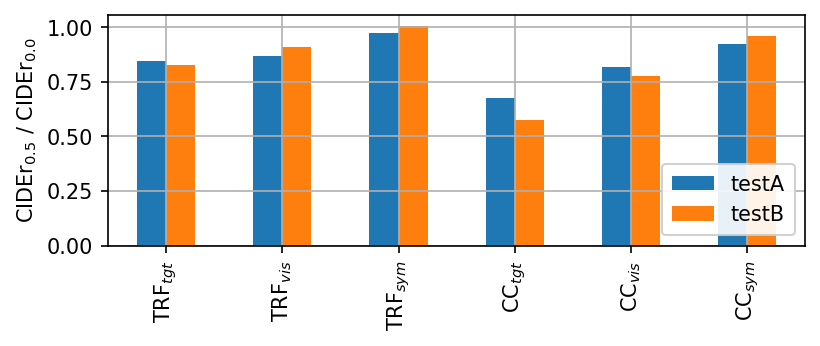

In [11]:
noise = 0.5
selection = r.loc[r[('noise', '{}')] == noise][[
    ('testA', 'CIDEr'), ('testB', 'CIDEr'), 
    #('testA+', 'CIDEr'), ('testB+', 'CIDEr')
    ]]
selection.columns = [s[0] for s in selection.columns]
selection = selection

fig, ax = plt.subplots()
fig.dpi = 150
selection.plot(kind='bar', ax=ax, grid=True, figsize=(6,2))
#ax = df.plot(kind='bar') # "same" as above
#plt.title(f'CIDEr decline (noise {str(noise)}, relative to 0.0)')
plt.xlabel('')
plt.ylabel('CIDEr$_{'+str(noise)+'}$ / CIDEr$_{0.0}$')

ax.legend(fancybox=True, framealpha=.9, shadow=False, borderpad=.5, loc='lower right', ncol=1)
figpath = join(figure_path, f'cider_decline_noise_{str(noise).replace(".", "-")}.png')
#print(f'save to {figpath}')
#plt.savefig(figpath, bbox_inches='tight')
plt.show()

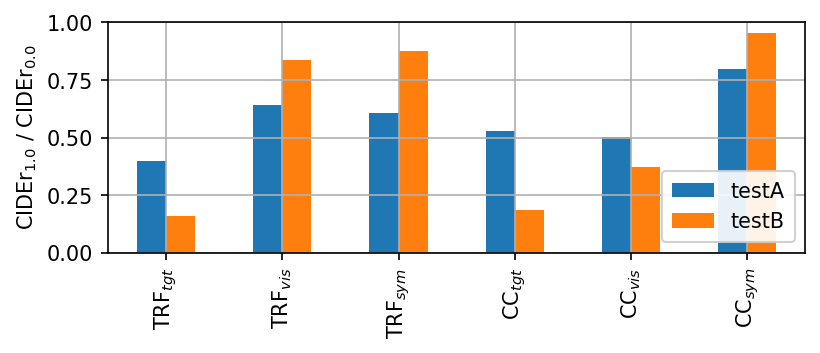

In [12]:
noise = 1.0
selection = r.loc[r[('noise', '{}')] == noise][[
    ('testA', 'CIDEr'), ('testB', 'CIDEr'), 
    #('testA+', 'CIDEr'), ('testB+', 'CIDEr')
    ]]
selection.columns = [s[0] for s in selection.columns]
selection = selection

fig, ax = plt.subplots()
fig.dpi = 150
selection.plot(kind='bar', ax=ax, grid=True, figsize=(6,2))
#ax = df.plot(kind='bar') # "same" as above
#plt.title(f'CIDEr decline (noise {str(noise)}, relative to 0.0)')
plt.xlabel('')
plt.ylabel('CIDEr$_{'+str(noise)+'}$ / CIDEr$_{0.0}$')

ax.legend(fancybox=True, framealpha=.9, shadow=False, borderpad=.5, loc='lower right', ncol=1)
figpath = join(figure_path, f'cider_decline_noise_{str(noise).replace(".", "-")}.png')
#print(f'save to {figpath}')
#plt.savefig(figpath, bbox_inches='tight')
plt.show()

In [13]:
splits = ['testA', 'testB', 'testA+', 'testB+']
columns = [(s, m) for s in splits for m in metrics]

system_slices = []
for a in ['TRF', 'CC']:
    for ctx in ['vis', 'tgt', 'sym']:
        slice = full_table[
            full_table.apply(lambda x: a+'$_{'+ctx in x.name, axis=1)
        ]
        reference_vals = slice.loc[slice['noise', '{}'] == 0.0][columns].values
        abs_diff = slice.copy()
        abs_diff[columns] = abs_diff[columns] - reference_vals
        system_slices.append(abs_diff)

r = pd.concat(system_slices)
r = r.sort_values(by=[('architecture', '{}'), ('context', '{}'), ('noise', '{}')], ascending=[False, True, True])
r.round(2)

noise architecture    context  testA               testB         \
               {}           {}         {} Bleu_1 Bleu_2 CIDEr Bleu_1 Bleu_2   
system                                                                        
TRF$_{tgt}$   0.0          trf  nocontext   0.00   0.00  0.00   0.00   0.00   
TRF$_{tgt}$   0.5          trf  nocontext  -0.06  -0.03 -0.13  -0.05  -0.03   
TRF$_{tgt}$   1.0          trf  nocontext  -0.20  -0.19 -0.52  -0.26  -0.21   
TRF$_{vis}$   0.0          trf     global   0.00   0.00  0.00   0.00   0.00   
TRF$_{vis}$   0.5          trf     global  -0.05  -0.04 -0.12  -0.05  -0.03   
TRF$_{vis}$   1.0          trf     global  -0.12  -0.10 -0.34  -0.06  -0.03   
TRF$_{sym}$   0.0          trf      scene   0.00   0.00  0.00   0.00   0.00   
TRF$_{sym}$   0.5          trf      scene  -0.01   0.01 -0.02  -0.01   0.00   
TRF$_{sym}$   1.0          trf      scene  -0.12  -0.11 -0.33  -0.04  -0.02   
CC$_{tgt}$    0.0       clpgpt  nocontext   0.00   0.00  0.00   0.00   0.00   
CC$_{tgt}$    0.5       clpgpt  nocontext  -0.10  -0.09 -0.23  -0.10  -0.08   
CC$_{tgt}$    1.0       clpgpt  nocontext  -0.12  -0.14 -0.33  -0.18  -0.17   
CC$_{vis}$    0.0       clpgpt     global   0.00   0.00  0.00   0.00   0.00   
CC$_{vis}$    0.5       clpgpt     global  -0.06  -0.07 -0.17  -0.08  -0.06   
CC$_{vis}$    1.0       clpgpt     global  -0.17  -0.15 -0.46  -0.20  -0.16   
CC$_{sym}$    0.0       clpgpt      scene   0.00   0.00  0.00   0.00   0.00   
CC$_{sym}$    0.5       clpgpt      scene  -0.01  -0.01 -0.05   0.01  -0.00   
CC$_{sym}$    1.0       clpgpt      scene  -0.03  -0.04 -0.13  -0.01  -0.02   

                  testA+              testB+               
            CIDEr Bleu_1 Bleu_2 CIDEr Bleu_1 Bleu_2 CIDEr  
system                                                     
TRF$_{tgt}$  0.00   0.00   0.00  0.00   0.00   0.00  0.00  
TRF$_{tgt}$ -0.22  -0.07  -0.05 -0.14  -0.07  -0.04 -0.15  
TRF$_{tgt}$ -1.08  -0.20  -0.16 -0.58  -0.29  -0.17 -0.64  
TRF$_{vis}$  0.00   0.00   0.00  0.00   0.00   0.00  0.00  
TRF$_{vis}$ -0.12  -0.07  -0.06 -0.15  -0.03  -0.02 -0.11  
TRF$_{vis}$ -0.22  -0.17  -0.16 -0.49  -0.08  -0.06 -0.26  
TRF$_{sym}$  0.00   0.00   0.00  0.00   0.00   0.00  0.00  
TRF$_{sym}$  0.01  -0.01  -0.00 -0.07  -0.01   0.00 -0.04  
TRF$_{sym}$ -0.16  -0.16  -0.14 -0.47  -0.07  -0.05 -0.23  
CC$_{tgt}$   0.00   0.00   0.00  0.00   0.00   0.00  0.00  
CC$_{tgt}$  -0.37  -0.02  -0.02 -0.06  -0.02  -0.00 -0.06  
CC$_{tgt}$  -0.72  -0.15  -0.14 -0.50  -0.19  -0.12 -0.47  
CC$_{vis}$   0.00   0.00   0.00  0.00   0.00   0.00  0.00  
CC$_{vis}$  -0.28  -0.04  -0.03 -0.09  -0.03  -0.02 -0.07  
CC$_{vis}$  -0.78  -0.16  -0.14 -0.47  -0.13  -0.09 -0.35  
CC$_{sym}$   0.00   0.00   0.00  0.00   0.00   0.00  0.00  
CC$_{sym}$  -0.05  -0.08  -0.08 -0.28  -0.04  -0.03 -0.13  
CC$_{sym}$  -0.05  -0.12  -0.12 -0.41  -0.05  -0.03 -0.17